In [93]:
# bibliotecas
import scipy.io
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib 
import pandas as pd
import numpy as np
import pickle
import random
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_score
import seaborn as sns
from tqdm import tqdm
from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["axes.grid"] = False

In [83]:
# pegar somente amostras com QA60 (pegar <=0) e NUVEM_SOMBRA (pegar diferente de Cloud)
data = pd.read_excel('4647_dataset_clorofila_classif_iqar.xlsx')
df_mask = data['Dominio'] == 'Estados_Unidos'
data = data[df_mask]
df_filtro = data.loc[(data['QA60'] <= 0) & (data['NUVEM_SOMBRA'] != 'CLOUD')]
# apagar linhas que contem NaN
df_filtro = df_filtro.dropna()
# filtrar so para bandas e classe
df = df_filtro[['BAND_1','BAND_2','BAND_3','BAND_4','BAND_5','BAND_6','BAND_7','BAND_8','BAND_8A','BAND_9','BAND_11','BAND_12','Classe']]
df['Classe'] = df['Classe'] - 1
df

,BAND_1,BAND_2,BAND_3,BAND_4,BAND_5,BAND_6,BAND_7,BAND_8,BAND_8A,BAND_9,BAND_11,BAND_12,Classe
0,31.0,51,16,1,1,1,1.0,1,1.0,1.0,1,1,0
1,31.0,51,16,1,1,1,1.0,1,1.0,1.0,1,1,0
2,31.0,51,16,1,1,1,1.0,1,1.0,1.0,1,1,0
3,31.0,51,16,1,1,1,1.0,1,1.0,1.0,1,1,0
4,31.0,51,16,1,1,1,1.0,1,1.0,1.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4250,2354.0,3377,3374,3267,3581,3857,3978.0,4320,4081.0,3659.0,3620,3277,0
4267,3416.0,3987,3919,3772,4162,4941,5198.0,5331,5291.0,5848.0,4112,3400,0
4268,3416.0,3987,3919,3772,4162,4941,5198.0,5331,5291.0,5848.0,4112,3400,1
4324,4043.0,5094,4724,4466,4746,5105,5109.0,5666,5066.0,6588.0,4550,3784,5


In [84]:
# contar classes
print('Quantidade por classe:')
print(df['Classe'].value_counts())

# filtrar por classe
df_1 = df[df['Classe']==0]
df_2 = df[df['Classe']==1]
df_3 = df[df['Classe']==2]
df_4 = df[df['Classe']==3]
df_5 = df[df['Classe']==4]
df_6 = df[df['Classe']==5]

Quantidade por classe:
4    551
3    376
2    260
5    249
1    233
0    161
Name: Classe, dtype: int64


In [85]:
# deixar classe 5 como sendo anomalia e o o resto como normal
df_anomalia = df_6
df_normal = pd.concat([df_1, df_2, df_3, df_4, df_5])
df_anomalia.loc[:,'Classe'] = 1
df_normal.loc[:,'Classe'] = 0

print('Quantidade por classe:')
print(df_normal['Classe'].value_counts())
print(df_anomalia['Classe'].value_counts())

Quantidade por classe:
0    1581
Name: Classe, dtype: int64
1    249
Name: Classe, dtype: int64


In [87]:
#separar treino e teste
qtd_amostras_treino = 1581-249

randomlist = random.sample(range(0, df_normal.shape[0]), qtd_amostras_treino)
df_normal_train = df_normal.iloc[randomlist]
df_normal_test = df_normal.drop(df_normal.index[randomlist])

df_anomalia_test = df_anomalia

print('Classe 0 - treino:', df_normal_train.shape[0], '/ teste:', df_normal_test.shape[0])
print('Classe 1 - teste:', df_anomalia_test.shape[0])

Classe 0 - treino: 1332 / teste: 249
Classe 1 - teste: 249


In [88]:
# concatenar dataframes
df_train = df_normal_train
frames_test = [df_normal_test, df_anomalia_test]
df_test = pd.concat(frames_test)
#print('Tamanho train:', df_train.shape)
#print('Tamanho test:', df_test.shape)

# separar entrada e rotulo do treino e teste
X_train = df_train.to_numpy()[:,:12]
y_train = df_train.to_numpy()[:,12].astype(int)
X_test = df_test.to_numpy()[:,:12]
y_test = df_test.to_numpy()[:,12].astype(int)

print('Tamanho train:', X_train.shape, '/ rotulos:', y_train.shape)
print('Tamanho test:', X_test.shape, '/ rotulos:', y_test.shape)

Tamanho train: (1332, 12) / rotulos: (1332,)
Tamanho test: (498, 12) / rotulos: (498,)


In [89]:
#padronizando dados antes do treinamento
scaler = StandardScaler()

norm_X_train = scaler.fit_transform(X_train)
norm_X_test = scaler.transform(X_test)

In [ ]:
'''# pca

import plotly.express as px
from sklearn.decomposition import PCA

X = df.loc[:, df.columns != 'Classe']

pca = PCA(n_components=3)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=df['Classe'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

# SVM One Class

In [94]:
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
gamma = ['scale', 'auto']
nu = [0.01, 0.1, 0.5, 0.8, 0.99]

resultados_svm = []

for a in tqdm(kernel):
    for b in gamma:
        for c in nu:
            grid_svm = OneClassSVM(kernel=a, gamma=b, nu=c)
            grid_svm.fit(norm_X_train)
            grid_svm_predictions = grid_svm.predict(norm_X_test)
            grid_svm_predictions[grid_svm_predictions == 1] = 0
            grid_svm_predictions[grid_svm_predictions == -1] = 1
            #print('Acuracia: ', accuracy_score(y_test, grid_svm_predictions),'\n')
            resultados_svm.append(a)
            resultados_svm.append(b)
            resultados_svm.append(c)
            resultados_svm.append(accuracy_score(y_test, grid_svm_predictions))
            resultados_svm.append(precision_score(y_test, grid_svm_predictions))
            resultados_svm.append(recall_score(y_test, grid_svm_predictions))
            resultados_svm.append(f1_score(y_test, grid_svm_predictions))
            
resultados_svm_df = pd.DataFrame(np.array(resultados_svm).reshape((int(len(resultados_svm)/7), 7)), columns=['kernel', 'gamma', 'nu', 'acuracia', 'precisao', 'revocacao', 'F1-score'])
resultados_svm_df.sort_values('F1-score', ascending = False)

100%|██████████| 4/4 [00:02<00:00,  1.76it/s]


,kernel,gamma,nu,acuracia,precisao,revocacao,F1-score
4,linear,scale,0.99,0.678714859437751,0.6449511400651465,0.7951807228915663,0.7122302158273381
9,linear,auto,0.99,0.678714859437751,0.6449511400651465,0.7951807228915663,0.7122302158273381
39,sigmoid,auto,0.99,0.5060240963855421,0.503030303030303,1.0,0.6693548387096775
34,sigmoid,scale,0.99,0.5060240963855421,0.503030303030303,1.0,0.6693548387096775
19,poly,auto,0.99,0.5,0.5,0.9919678714859438,0.6648721399730821
14,poly,scale,0.99,0.5,0.5,0.9919678714859438,0.6648721399730821
24,rbf,scale,0.99,0.4979919678714859,0.49897750511247446,0.9799196787148594,0.6612466124661247
29,rbf,auto,0.99,0.4979919678714859,0.49897750511247446,0.9799196787148594,0.6612466124661247
38,sigmoid,auto,0.8,0.5401606425702812,0.5248756218905473,0.8473895582329317,0.6482334869431644
33,sigmoid,scale,0.8,0.5401606425702812,0.5248756218905473,0.8473895582329317,0.6482334869431644


# Florestas isoladas

In [95]:
n_estimators= list(range(100, 800, 25))
max_samples= list(range(100, 500, 25))
contamination= [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5]
max_features= [1, 3, 7 ,10, 12]
bootstrap= [True, False]

resultados_if = []

for a in tqdm(n_estimators):
    for b in max_samples:
        for c in contamination:
            for d in max_features:
                for e in bootstrap:
                    grid_if = IsolationForest(n_estimators=a, max_samples=b, contamination=c, max_features=d, bootstrap=e ,n_jobs=-1)
                    grid_if.fit(norm_X_train)
                    grid_if_predictions = grid_if.predict(norm_X_test)
                    grid_if_predictions[grid_if_predictions == 1] = 0
                    grid_if_predictions[grid_if_predictions == -1] = 1
                    #print('Acuracia: ', accuracy_score(y_test, grid_svm_predictions),'\n')
                    resultados_if.append(a)
                    resultados_if.append(b)
                    resultados_if.append(c)
                    resultados_if.append(d)
                    resultados_if.append(e)
                    resultados_if.append(accuracy_score(y_test, grid_if_predictions))
                    resultados_if.append(precision_score(y_test, grid_if_predictions))
                    resultados_if.append(recall_score(y_test, grid_if_predictions))
                    resultados_if.append(f1_score(y_test, grid_if_predictions))
            
resultados_if_df = pd.DataFrame(np.array(resultados_if).reshape((int(len(resultados_if)/9), 9)), columns=['n_estimators', 'max_samples', 'contamination', 'max_features', 'bootstrap', 'acuracia', 'precisao', 'revocacao', 'F1-score'])
resultados_if_df.sort_values('F1-score', ascending = False)

100%|██████████| 28/28 [6:37:39<00:00, 852.11s/it]   


,n_estimators,max_samples,contamination,max_features,bootstrap,acuracia,precisao,revocacao,F1-score
1671,125.0,275.0,0.500,1.0,0.0,0.602410,0.577508,0.763052,0.657439
3281,150.0,450.0,0.500,1.0,0.0,0.598394,0.574018,0.763052,0.655172
10071,300.0,475.0,0.500,1.0,0.0,0.596386,0.573620,0.751004,0.650435
3211,150.0,425.0,0.500,1.0,0.0,0.592369,0.570122,0.751004,0.648180
12241,350.0,450.0,0.500,1.0,0.0,0.594378,0.572308,0.746988,0.648084
...,...,...,...,...,...,...,...,...,...
15475,425.0,425.0,0.001,7.0,0.0,0.495984,0.000000,0.000000,0.000000
15474,425.0,425.0,0.001,7.0,1.0,0.495984,0.000000,0.000000,0.000000
6376,225.0,375.0,0.001,10.0,1.0,0.495984,0.000000,0.000000,0.000000
6375,225.0,375.0,0.001,7.0,0.0,0.495984,0.000000,0.000000,0.000000


# SVM One Class

Melhores hiperparametros do modelo: {'gamma': 'scale', 'kernel': 'linear', 'nu': 0.01}

Acuracia:  0.4658385093167702
              precision    recall  f1-score   support

           0       0.48      0.77      0.59       161
           1       0.41      0.16      0.23       161

    accuracy                           0.47       322
   macro avg       0.45      0.47      0.41       322
weighted avg       0.45      0.47      0.41       322



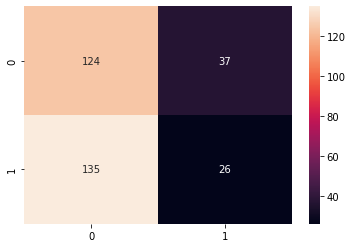

In [31]:
# treinar svm

# pesquisa em grade
param_grid_svm = {'gamma': ['scale', 'auto'],
                  'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                  'nu': [0.01, 0.1, 0,5, 1]}

#grid_svm = OneClassSVM(gamma='scale', nu=0.01) #GridSearchCV(SVC(),param_grid_svm,refit=True, n_jobs=-1)
grid_svm = GridSearchCV(OneClassSVM(),param_grid_svm, refit=True, scoring="recall", n_jobs=-1)
grid_svm.fit(norm_X_train)

print('Melhores hiperparametros do modelo:', grid_svm.best_params_)

#################################

# salvar o modelo no disco
#pickle.dump(grid_svm, open(data_salvar_modelo+'_svm_com_cluster.pkl', 'wb'))

# carregar o modelo salvo em disco
#loaded_model = pickle.load(open(data_salvar_modelo+'svm.pkl', 'rb'))
#result = loaded_model.score(norm_X_teste_com_cluster, y_teste)
#print(result)

#################################

# testar
grid_svm_predictions = grid_svm.predict(norm_X_test)

# Inlier Prediction: +1
# Outlier Prediction: -1
grid_svm_predictions[grid_svm_predictions == 1] = 0
grid_svm_predictions[grid_svm_predictions == -1] = 1

print('\nAcuracia: ', accuracy_score(y_test, grid_svm_predictions))
#print(confusion_matrix(y_teste,grid_svm_predictions))
print(classification_report(y_test, grid_svm_predictions))

# matrix de confusao
cm = confusion_matrix(y_test, grid_svm_predictions)
f = sns.heatmap(cm, annot=True, fmt='d')

In [32]:
grid_svm_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,

In [33]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

# Florestas isoladas

Melhores hiperparametros do modelo: {'bootstrap': True, 'contamination': 0.001, 'max_features': 5, 'max_samples': 100, 'n_estimators': 100}

Acuracia:  0.5031055900621118
              precision    recall  f1-score   support

           0       0.50      0.99      0.67       161
           1       0.67      0.01      0.02       161

    accuracy                           0.50       322
   macro avg       0.58      0.50      0.35       322
weighted avg       0.58      0.50      0.35       322



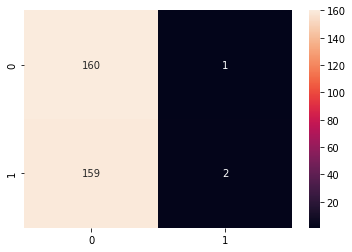

In [29]:
from sklearn.ensemble import IsolationForest

# treinar florestas isoladas

# pesquisa em grade
param_grid_if = {'n_estimators': list(range(100, 800, 5)), 
              'max_samples': list(range(100, 500, 5)), 
              'contamination': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5], 
              'max_features': [5,10,15], 
              'bootstrap': [True, False]}

grid_if = GridSearchCV(IsolationForest(), param_grid_if, refit=True, scoring="precision", n_jobs=-1)
grid_if.fit(norm_X_train)

print('Melhores hiperparametros do modelo:', grid_if.best_params_)

#################################

# salvar o modelo no disco
#pickle.dump(grid_if, open(data_salvar_modelo+'_svm_com_cluster.pkl', 'wb'))

# carregar o modelo salvo em disco
#loaded_model = pickle.load(open(data_salvar_modelo+'svm.pkl', 'rb'))
#result = loaded_model.score(norm_X_teste_com_cluster, y_teste)
#print(result)

#################################

# testar
grid_if_predictions = grid_if.predict(norm_X_test)

# Inlier Prediction: +1
# Outlier Prediction: -1
grid_if_predictions[grid_if_predictions == 1] = 0
grid_if_predictions[grid_if_predictions == -1] = 1

print('\nAcuracia: ', accuracy_score(y_test, grid_if_predictions))
#print(confusion_matrix(y_teste,grid_if_predictions))
print(classification_report(y_test, grid_if_predictions))

# matrix de confusao
cm = confusion_matrix(y_test, grid_if_predictions)
f = sns.heatmap(cm, annot=True, fmt='d')